## Import libs

In [2]:
import os
import random
import pathlib
import cv2
import numpy as np
import pandas as pd

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras import models, layers, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

## Declare constants

In [33]:
FACES_DATA_PATH = 'D:\Datasets\lfw-deepfunneled'
CARS_TRAIN_DATA_PATH = 'D:\Datasets\cars_train'
CARS_TEST_DATA_PATH = 'D:\Datasets\cars_test'
PLATES_DATA_PATH = 'D:\Datasets\CarsReId_LP'
dataset_size = 7000
train_size = 5000
test_size = 2000
image_size = (32, 32)
input_shape = (32, 32, 3)
num_classes = 10

## Define functions

In [16]:
# Get image paths in a certain folder
def get_paths(data_path, extension):
    return list(pathlib.Path(data_path).glob('**/*.' + extension))

In [50]:
# Get image paths from csv file
# csv: image_path, train
def get_paths_csv(csv_path):
    data = pd.read_csv(csv_path)
    train_image_paths = list(os.path.join(PLATES_DATA_PATH, path) for path in data[data['train']==1]['image_path'])
    test_image_paths = list(os.path.join(PLATES_DATA_PATH, path) for path in data[data['train']==0]['image_path'])
    return train_image_paths, test_image_paths

In [7]:
# Define function that gets random images from the dataset 
# using glob search by pattern method of Pathlib
def get_random_images(image_paths, image_size, num_images):
    random.shuffle(image_paths)
    images = []
    for path in image_paths[:num_images]:
        path = os.path.abspath(path)
        image = cv2.imread(path)
        image = cv2.resize(image, image_size)
        image = img_to_array(image)
        images.append(image)
    return np.array(images)

In [58]:
# Define function that creates train label and test label
def generate_labels(label, train_size, test_size):
    train_label = label*np.ones((train_size, 1)).astype('int')
    test_label = label*np.ones((test_size, 1)).astype('int')
    return train_label, test_label

In [68]:
# Define function that combines two datasets
def combine_datasets(train_data1, train_label1, test_data1, test_label1, 
                 train_data2, train_label2, test_data2, test_label2):
    # Combine data
    train_data1 = np.concatenate((train_data1, train_data2), axis = 0)
    test_data1 = np.concatenate((test_data1, test_data2), axis = 0)
    # Combine labels
    train_label1 = np.r_[train_label1, train_label2]
    test_label1 = np.r_[test_label1, test_label2]
    return train_data1, train_label1, test_data1, test_label1

In [94]:
# Define function that normalizes train data and test data
def normalize_data(train_data, test_data):
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255
    train_data_mean = np.mean(train_data, axis=0)
    train_data -= train_data_mean
    test_data -= train_data_mean
    return train_data, test_data

In [90]:
def convert_labels_to_categorical(train_label, test_label, num_classes):
    train_label = keras.utils.to_categorical(train_label, num_classes)
    test_label = keras.utils.to_categorical(test_label, num_classes)
    return train_label, test_label

## Step 1. Load datasets

In [12]:
# Load CIFAR-10 dataset
(train_data, train_label), (test_data, test_label) = cifar10.load_data()

In [17]:
# Load and split ‘Labelled Faces in the Wild’ dataset (Faces dataset)
image_paths = get_paths(FACES_DATA_PATH, 'jpg')
faces = get_random_images(image_paths, image_size, dataset_size)
faces_train_data, faces_test_data = train_test_split(faces, test_size=test_size, random_state = 1)
faces.shape

In [27]:
# Load train set of Cars dataset
image_paths = get_paths(CARS_TRAIN_DATA_PATH, 'jpg')
cars_train_data = get_random_images(image_paths, image_size, train_size)
cars_train_data.shape

[WindowsPath('D:/Datasets/cars_train/00192.jpg'),
 WindowsPath('D:/Datasets/cars_train/06880.jpg'),
 WindowsPath('D:/Datasets/cars_train/03235.jpg'),
 WindowsPath('D:/Datasets/cars_train/06833.jpg'),
 WindowsPath('D:/Datasets/cars_train/07926.jpg'),
 WindowsPath('D:/Datasets/cars_train/03413.jpg'),
 WindowsPath('D:/Datasets/cars_train/03474.jpg'),
 WindowsPath('D:/Datasets/cars_train/05713.jpg'),
 WindowsPath('D:/Datasets/cars_train/02542.jpg'),
 WindowsPath('D:/Datasets/cars_train/00103.jpg'),
 WindowsPath('D:/Datasets/cars_train/01888.jpg'),
 WindowsPath('D:/Datasets/cars_train/00596.jpg'),
 WindowsPath('D:/Datasets/cars_train/04285.jpg'),
 WindowsPath('D:/Datasets/cars_train/07416.jpg'),
 WindowsPath('D:/Datasets/cars_train/04608.jpg'),
 WindowsPath('D:/Datasets/cars_train/00246.jpg'),
 WindowsPath('D:/Datasets/cars_train/04967.jpg'),
 WindowsPath('D:/Datasets/cars_train/06543.jpg'),
 WindowsPath('D:/Datasets/cars_train/07449.jpg'),
 WindowsPath('D:/Datasets/cars_train/04687.jpg'),


In [28]:
# Load test set f Cars dataset
image_paths = get_paths(CARS_TEST_DATA_PATH, 'jpg')
cars_test_data = get_random_images(image_paths, image_size, test_size)

In [55]:
# Load train set of Plates dataset
train_image_paths, test_image_paths = get_paths_csv(PLATES_DATA_PATH+'\\'+'trainVal.csv')
plates_train_data = get_random_images(train_image_paths, image_size, train_size)

In [56]:
# Load test set of Plates dataset
plates_test_data = get_random_images(test_image_paths, image_size, test_size)

## Step 2: Combine datasets

In [59]:
# Create Faces train labels, Faces test labels
faces_train_label, faces_test_label = generate_labels(num_classes, train_size, test_size)

In [ ]:
num_classes += 1

In [69]:
# Combine Faces dataset with CIFAR-10 dataset to have CIFARE-11 dataset: 67000 images in 11 classes.
train_data, train_label, test_data, test_label = combine_datasets(train_data, train_label, 
                                                                  test_data, test_label, 
                                                                  faces_train_data, faces_train_label, 
                                                                  faces_test_data, faces_test_label)

In [61]:
# Create Cars train labels, Cars test labels
cars_train_label, cars_test_label = generate_labels(num_classes, train_size, test_size)

In [ ]:
num_classes += 1

In [70]:
# Combine Cars dataset with CIFAR-11 dataset to have CIFARE-12 dataset: 74000 images in 12 classes.
train_data, train_label, test_data, test_label = combine_datasets(train_data, train_label, 
                                                                  test_data, test_label, 
                                                                  cars_train_data, cars_train_label, 
                                                                  cars_test_data, cars_test_label)

In [63]:
# Create Plates train labels, Plates test labels
plates_train_label, plates_test_label = generate_labels(num_classes, train_size, test_size)

In [ ]:
num_classes += 1

In [71]:
# Combine Faces dataset with CIFAR-12 dataset to have CIFARE-13 dataset: 81000 images in 13 classes.
train_data, train_label, test_data, test_label = combine_datasets(train_data, train_label, 
                                                                  test_data, test_label, 
                                                                  plates_train_data, plates_train_label, 
                                                                  plates_test_data, plates_test_label)

## Step 3: Build a CNN network to classify an image across 13 classes 

In [91]:
# Normalize input data
train_data, test_data = normalize_data(train_data, test_data)

(65000, 32, 32, 3)


In [92]:
# Convert labels to categorical one-hot encoding
train_label, test_label = convert_labels_to_categorical(train_label, test_label, num_classes)

In [95]:
# Create the model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size =(3, 3), input_shape=input_shape, padding='same', activation='relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization(axis = -1))          
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same'))
model.add(BatchNormalization(axis = -1))          
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis = -1)) 
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization(axis = -1)) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
#sgd = SGD(lr=0.01, momentum=0.9)
rmsprop = RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [96]:
batch_size = 32
epochs = 50
# Data augmentation
datagen = ImageDataGenerator(
        #zoom_range=0.2, # randomly zoom into images
        #rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly horizontal flip images
        vertical_flip=False)  # randomly vertical flip images

# Model checkpoint to save best model
checkpoint = ModelCheckpoint('saved_models/weights.best.from_scratch.hdf5', 
                             verbose=0, monitor='val_loss',save_best_only=False, mode='max')
#stopper = callbacks.EarlyStopping(monitor='val_acc', patience=3, mode='auto')
# Fit the model
history = model.fit_generator(datagen.flow(train_data, train_label, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(test_data, test_label),
                              workers=4,
                              callbacks=[checkpoint])
#history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, 
                    #batch_size=16, callbacks=[checkpoint])

Epoch 1/50
2032/2032 [==============================] - 214s 105ms/step - loss: 1.6832 - acc: 0.4623 - val_loss: 0.9615 - val_acc: 0.6716
Epoch 2/50
2032/2032 [==============================] - 208s 102ms/step - loss: 1.0921 - acc: 0.6236 - val_loss: 0.7467 - val_acc: 0.7493
Epoch 3/50
2032/2032 [==============================] - 208s 103ms/step - loss: 0.9151 - acc: 0.6840 - val_loss: 0.6288 - val_acc: 0.7805
Epoch 4/50
2032/2032 [==============================] - 209s 103ms/step - loss: 0.8120 - acc: 0.7210 - val_loss: 0.6296 - val_acc: 0.7810
Epoch 5/50
2032/2032 [==============================] - 212s 104ms/step - loss: 0.7502 - acc: 0.7422 - val_loss: 0.5144 - val_acc: 0.8241
Epoch 6/50
2032/2032 [==============================] - 202s 99ms/step - loss: 0.7021 - acc: 0.7584 - val_loss: 0.4867 - val_acc: 0.8324
Epoch 7/50
2032/2032 [==============================] - 198s 98ms/step - loss: 0.6651 - acc: 0.7715 - val_loss: 0.4699 - val_acc: 0.8364
Epoch 8/50
2032/2032 [==============

## Step 6: Report the results

In [97]:
history_dict = history.history
epochs = len(history_dict['loss']) + 1
epochs = range(1, epochs)

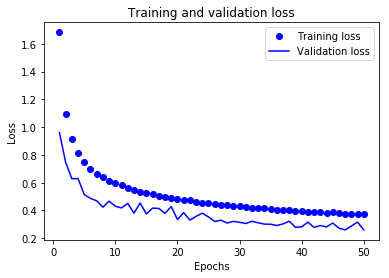

In [98]:
# Plot the training/validation loss as collected during training
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

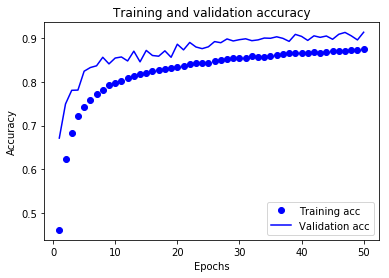

In [99]:
# Plot the training/validation accuracy as collected during training
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [100]:
# Final evaluation of the model
model1 = load_model("saved_models/weights.best.from_scratch.hdf5")
scores = model1.evaluate(test_data, test_label, verbose=0)
print("Loss: %.4f" % scores[0])
print("Accuracy: %.2f%%" % (scores[1]*100))

Loss: 0.2600
Accuracy: 91.29%
